In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import polars as pl
import glob
import re
import ast
from pathlib import Path

In [57]:
def procesar_y_expandir_logs(ruta_busqueda: str) -> pl.DataFrame:
    """
    Busca archivos de log, extrae información relevante y expande los
    hiperparámetros en columnas separadas dentro de un DataFrame de Polars.

    Args:
        ruta_busqueda (str): Patrón de búsqueda para glob (ej. 'logs/*.out').
    """
    lista_archivos = glob.glob(ruta_busqueda)

    if not lista_archivos:
        print(f"No se encontraron archivos con el patrón '{ruta_busqueda}'.")
        return pl.DataFrame()

    datos_extraidos = []

    # Expresiones regulares ajustadas
    regex = {
        'n_jobs': re.compile(r"N_JOBS=(\d+)"),
        'n_samples': re.compile(r"N_SAMPLES=(\d+)"),
        'slurm_cpus_per_task': re.compile(r"SLURM_CPUS_PER_TASK=(\d+)"),
        'inner_n_jobs': re.compile(r"inner_n_jobs=(\d+)"),
        'tiempo_total': re.compile(r"TIEMPO TOTAL ENTRENAMIENTO \(pared\): ([\d\.]+) s"),
        # --- REGEX MEJORADA: Busca específicamente un string que empieza con { y termina con } ---
        'params': re.compile(r"params=(\{.*\})")
    }

    print(f"Procesando {len(lista_archivos)} archivo(s)...")

    for archivo_path in lista_archivos:
        path_obj = Path(archivo_path)
        with open(path_obj, 'r', encoding='utf-8') as f:
            contenido = f.read()

            # Diccionario base para esta fila de datos
            fila_datos = {
                'archivo': path_obj.name
            }

            # Extraer los datos básicos
            n_jobs = re.search(regex['n_jobs'], contenido)
            fila_datos['n_jobs'] = int(n_jobs.group(1)) if n_jobs else None

            n_samples = re.search(regex['n_samples'], contenido)
            fila_datos['n_samples'] = int(n_samples.group(1)) if n_samples else None

            slurm_cpus = re.search(regex['slurm_cpus_per_task'], contenido)
            fila_datos['slurm_cpus_per_task'] = int(slurm_cpus.group(1)) if slurm_cpus else None

            inner_n_jobs = re.search(regex['inner_n_jobs'], contenido)
            fila_datos['inner_n_jobs'] = int(inner_n_jobs.group(1)) if inner_n_jobs else None

            tiempo = re.search(regex['tiempo_total'], contenido)
            fila_datos['tiempo_total_entrenamiento'] = float(tiempo.group(1)) if tiempo else None

            # --- LÓGICA MEJORADA PARA PARSEAR Y EXPANDIR PARÁMETROS ---
            params_match = re.search(regex['params'], contenido)
            if params_match:
                # Obtenemos el string del diccionario capturado por el grupo 1
                params_string_limpio = params_match.group(1).strip()
                try:
                    # Parseamos el string a un diccionario de Python
                    params_dict = ast.literal_eval(params_string_limpio)
                    # Actualizamos el diccionario de la fila con los parámetros
                    fila_datos.update(params_dict)
                except (ValueError, SyntaxError):
                    print(f"Advertencia: No se pudieron parsear los parámetros en el archivo {path_obj.name}")
                    # Para depuración, imprime el string que falló
                    print(f"   ---> String problemático: '{params_string_limpio}'")

            datos_extraidos.append(fila_datos)

    # Polars creará automáticamente las columnas para todas las claves encontradas,
    # rellenando con 'null' los valores faltantes en cada fila.
    if not datos_extraidos:
        return pl.DataFrame()

    df = pl.DataFrame(datos_extraidos)
    return df

In [59]:
base_path=Path('logs')
file_glob = 'rnn_rnn_joblib_*.out'
df_resultados = procesar_y_expandir_logs(ruta_busqueda=base_path.joinpath(file_glob).as_posix())

Procesando 24 archivo(s)...


In [60]:
df_resultados

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init
str,i64,i64,i64,i64,f64,f64,list[i64],f64
"""rnn_rnn_joblib_14794_0.out""",1,5000,32,1,53.157,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_1.out""",2,5000,32,1,28.888,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_10.out""",16,10000,32,1,10.855,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_11.out""",32,10000,32,1,10.831,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_12.out""",1,20000,32,1,193.788,0.0001,[64],0.001
…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_14799_1.out""",2,40000,32,1,194.007,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_2.out""",4,40000,32,1,104.195,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_3.out""",8,40000,32,1,61.765,0.0001,[64],0.001


In [35]:
df_10k = pd.read_csv("timesN10k.txt", header=None, names=["N", "time"], sep="\t")
df_10k

,N,time
0,1,100.545
1,2,52.820
2,4,29.539
3,8,16.964
4,16,10.959
5,32,10.961


In [36]:
"""
N     time
0   1  100.545
1   2   52.820
2   4   29.539
3   8   16.964
4  16   10.959
5  32   10.961
"""

'\nN     time\n0   1  100.545\n1   2   52.820\n2   4   29.539\n3   8   16.964\n4  16   10.959\n5  32   10.961\n'

In [37]:
df_10k["speedup"] = df_10k["time"].iloc[0] / df_10k["time"]
df_10k["efficiency"] = df_10k["speedup"] / df_10k["N"]
df_10k

,N,time,speedup,efficiency
0,1,100.545,1.000000,1.000000
1,2,52.820,1.903540,0.951770
2,4,29.539,3.403805,0.850951
3,8,16.964,5.926963,0.740870
4,16,10.959,9.174651,0.573416
5,32,10.961,9.172977,0.286656


In [51]:
# get increment of speedup in percentaje
df_10k["speedup"].pct_change()

0         NaN
1    0.903540
2    0.788144
3    0.741276
4    0.547951
5   -0.000182
Name: speedup, dtype: float64

In [38]:
a0 = 2.5
a1 = 98.26
a2 = 0.889

y_hat = a0 + a1 / df_10k["N"] + a2 * df_10k["N"].apply(lambda x: math.log2(x))
y_hat

0    100.760000
1     52.519000
2     28.843000
3     17.449500
4     12.197250
5     10.015625
Name: N, dtype: float64

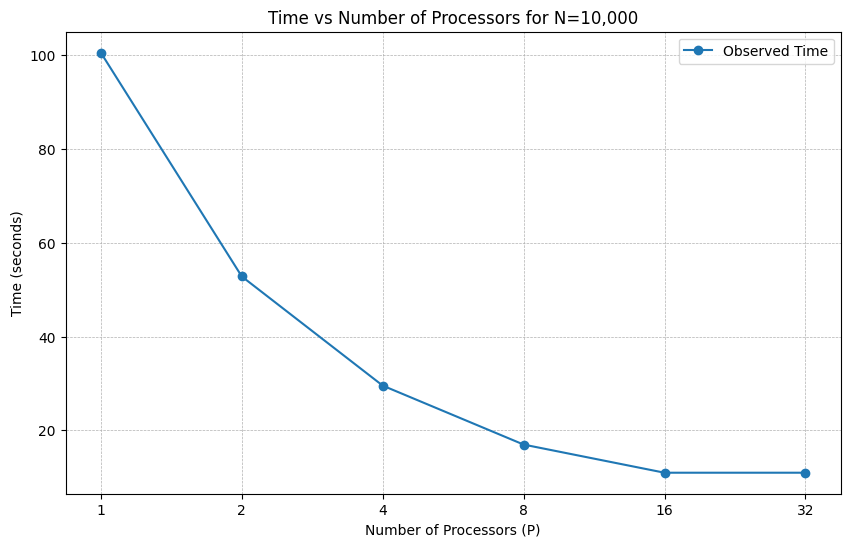

In [39]:
# plot time vs processors
plt.figure(figsize=(10, 6))
plt.plot(df_10k["N"], df_10k["time"], marker="o", label="Observed Time")
# plt.plot(df_10k["N"], y_hat, marker="x", linestyle="--", label="Fitted Model")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.xticks(df_10k["N"], df_10k["N"])
plt.xlabel("Number of Processors (P)")
plt.ylabel("Time (seconds)")
plt.title("Time vs Number of Processors for N=10,000")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
# plt.savefig("time_vs_processors_10k.png")
plt.show()

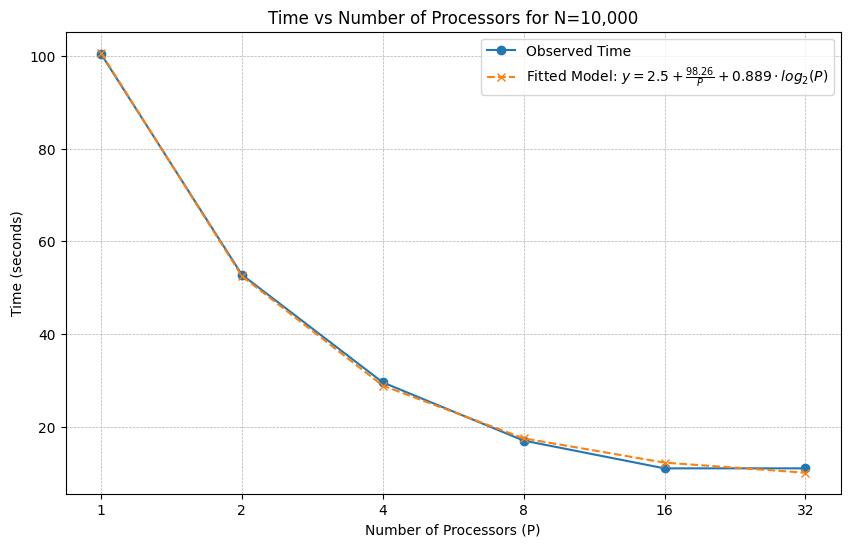

In [44]:
# plot time vs processors
plt.figure(figsize=(10, 6))
plt.plot(df_10k["N"], df_10k["time"], marker="o", label="Observed Time")
plt.plot(df_10k["N"], y_hat, marker="x", linestyle="--", label="Fitted Model: $y = 2.5 + \\frac{98.26}{P} + 0.889 \\cdot log_2(P)$")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.xticks(df_10k["N"], df_10k["N"])
plt.xlabel("Number of Processors (P)")
plt.ylabel("Time (seconds)")
plt.title("Time vs Number of Processors for N=10,000")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
# plt.savefig("time_vs_processors_10k.png")
plt.show()

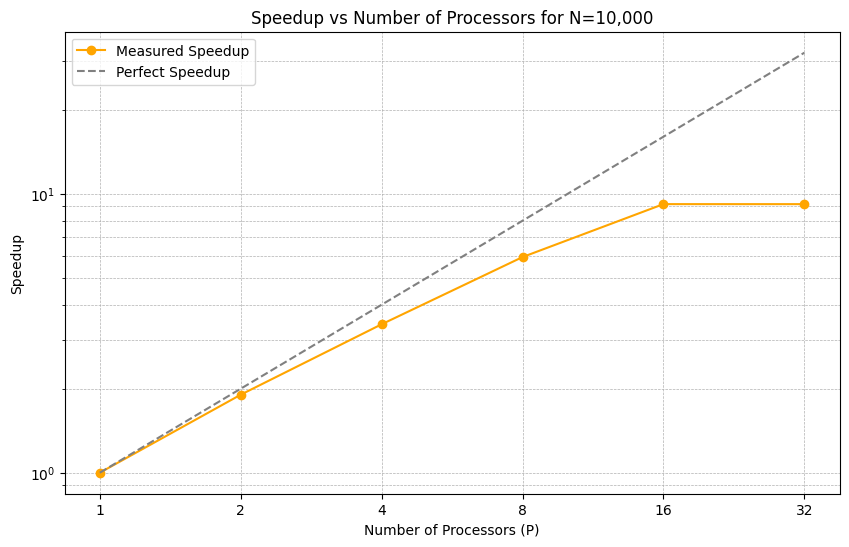

In [45]:
# plot speedup vs processors
plt.figure(figsize=(10, 6))
plt.plot(df_10k["N"], df_10k["speedup"], marker="o", color="orange", label="Measured Speedup")
plt.plot(df_10k["N"], df_10k["N"], linestyle="--", color="gray", label="Perfect Speedup")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xticks(df_10k["N"], df_10k["N"])
plt.xlabel("Number of Processors (P)")
plt.ylabel("Speedup")
plt.title("Speedup vs Number of Processors for N=10,000")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
# plt.savefig("speedup_vs_processors_10k.png")
plt.show()

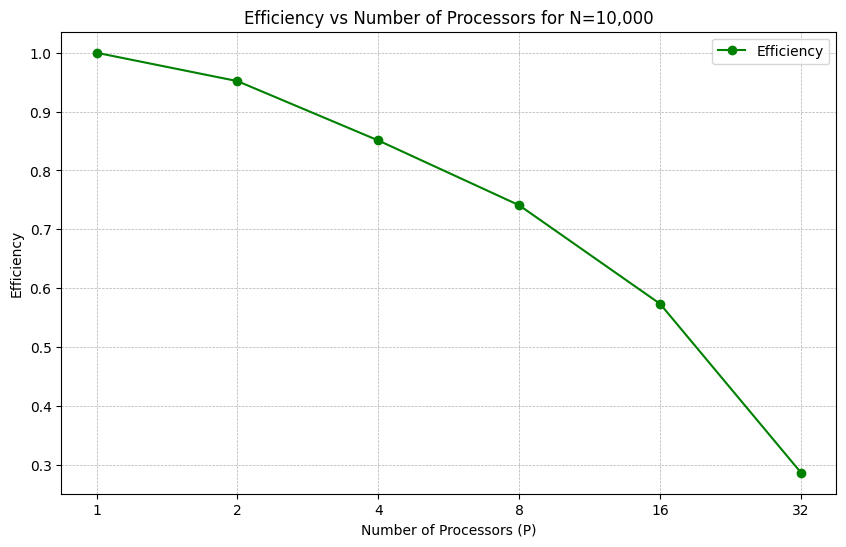

In [46]:
# plot efficiency vs processors
plt.figure(figsize=(10, 6))
plt.plot(df_10k["N"], df_10k["efficiency"], marker="o", color="green", label="Efficiency")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.xticks(df_10k["N"], df_10k["N"])
plt.xlabel("Number of Processors (P)")
plt.ylabel("Efficiency")
plt.title("Efficiency vs Number of Processors for N=10,000")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
# plt.savefig("efficiency_vs_processors_10k.png")
plt.show()